<a href="https://colab.research.google.com/github/workdd/MLOps_with_MLFlow/blob/main/scikit_learn_with_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLFlow를 활용한 MLOps 챕터4

# 사이킷런을 활용한 MLFlow (p124)

## 필수 라이브러리 설치 및 버전 확인

In [1]:
!pip install mlflow==1.10.0
#scikit-learn 1.2 버전 아래에서 진행해야 원활히 진행 가능
!pip install scikit-learn==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 100.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("scikit-learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))


Numpy: 1.22.4
Pandas: 1.5.3
matplotlib: 3.7.1
seaborn: 0.12.2
scikit-learn: 1.1.0
MLFlow: 1.10.0


## Databricks 연결

MLFlow Ui 사용을 위해 Databricks에 연결해야 함

In [5]:
!databricks configure --host https://community.cloud.databricks.com/
mlflow.set_tracking_uri("databricks")

databricks_email = "workdofficial@gmail.com"
mlflow_experiment = "scikit_learn_experiment"

# Databricks에 로그인, experiment가 없을 경우 새로 생성 후 연결
mlflow.set_experiment(f"/Users/{databricks_email}/{mlflow_experiment}")

Username: workdofficial@gmail.com
Password: 
Repeat for confirmation: 
INFO: '/Users/workdofficial@gmail.com/scikit_learn_experiment' does not exist. Creating a new experiment


## 데이터 처리

아래 사이트에서 신용카드 데이터셋 다운로드
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

다운로드 후 구글 드라이브에 업로드 해두기

In [7]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [11]:
google_drive = "/content/drive/MyDrive/"
data_path = google_drive + "creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


In [13]:
# 정상 및 이상 데이터 집합을 학습-테스트-검증 데이터 세트로 분할
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [14]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidate sets:\nx_validate: {} \ny_validate:{}".format(x_validate.shape, y_validate.shape))


Training sets:
x_train: (85588, 29) 
y_train:(85588,)

Testing sets:
x_test: (28531, 29) 
y_test:(28531,)

Validate sets:
x_validate: (28531, 29) 
y_validate:(28531,)


### 스케일러를 통한 데이터 확장

In [15]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# MLFlow를 통한 학습 및 평가 (p130)

In [16]:
def train(sk_model, x_train, y_train):
  sk_model = sk_model.fit(x_train, y_train)

  train_acc = sk_model.score(x_train, y_train)

  # MLFlow에 학습 정확도값을 추적하도록 설정
  mlflow.log_metric("train_acc", train_acc)

  print(f"Train Accuracy: {train_acc:.3%}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def evaluate(sk_model, x_test, y_test):
  eval_acc = sk_model.score(x_test, y_test)

  preds = sk_model.predict(x_test)
  auc_score = roc_auc_score(y_test, preds)

  # MLFlow에 테스트 정확도 및 정확도 점수를 추적하도록 설정
  mlflow.log_metric("eval_acc", eval_acc)
  mlflow.log_metric("auc_score", auc_score)

  print(f"Auc Score: {auc_score:.3%}")
  print(f"Eval Accuracy: {eval_acc:.3%}")

  roc_plot = plot_roc_curve(sk_model, x_test, y_test, name ='scikit-learn ROC Curve')
  plt.savefig("sklearn_roc_plot.png")
  plt.show()
  plt.clf()

  conf_matrix = confusion_matrix(y_test, preds)
  ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
  ax.invert_xaxis()
  ax.invert_yaxis()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title("Confusion Matrix")
  plt.savefig("sklearn_conf_matrix.png")

  # MLFlow에 로컬에 저장된 plot을 로깅하도록 설정
  mlflow.log_artifact("sklearn_roc_plot.png")
  mlflow.log_artifact("sklearn_conf_matrix.png")

# MLFlow 실행 로깅 및 확인 (p133)

Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


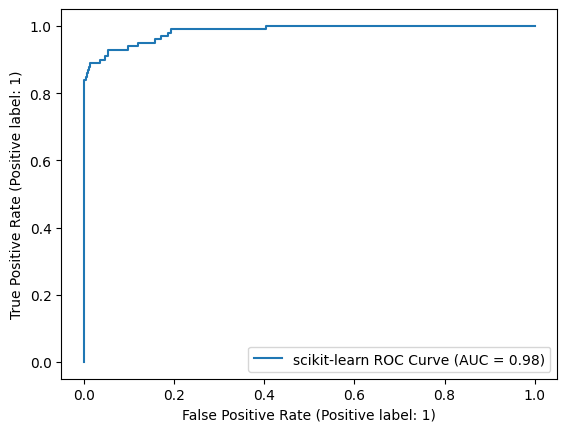

Model run:  af6dc2f1ce3d46d38bd5da8481afc358


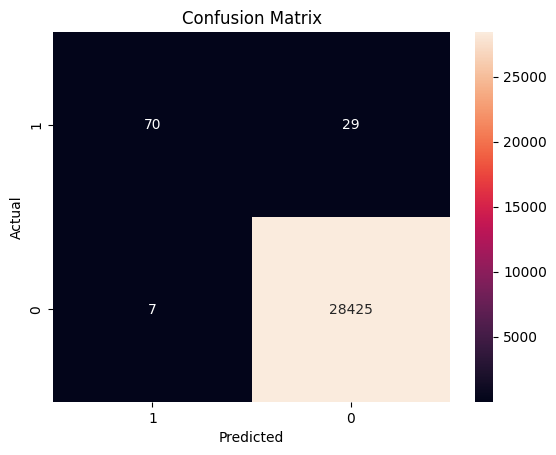

In [18]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')

# MLFlow 실험 이름 설정
mlflow.set_experiment(f"/Users/{databricks_email}/scikit_learn_experiment")

# MLFlow 실험 시작
with mlflow.start_run():
  train(sk_model, x_train, y_train)
  evaluate(sk_model, x_test, y_test)

  # MLFlow에 sk_model 모델 로깅
  mlflow.sklearn.log_model(sk_model, "log_reg_model")

  # 로깅된 데이터를 출력
  print("Model run: ", mlflow.active_run().info.run_uuid)

mlflow.end_run()

# MLFlow를 사용한 모델 검증 (파라미터 튜닝) (p143)

In [19]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [20]:
mlflow.set_experiment(f"/Users/{databricks_email}/sklearn_creditcard_broad_search")

logs = []

for f in range(len(anomaly_weights)):
  fold = 1
  accuracies = []
  auc_scores = []

  for train, test in kfold.split(x_validate, y_validate):
    with mlflow.start_run():
      weight = anomaly_weights[f]
      mlflow.log_param("anomaly_weight", weight)
      class_weights = {
          0: 1,
          1: weight
      }

      sk_model = LogisticRegression(random_state=None,
                                    max_iter=400,
                                    solver='newton-cg',
                                    class_weight=class_weights).fit(x_validate[train], y_validate[train])

      for h in range(40):
        print('-', end="")

      print(f"\nfold {fold}\nAnomaly Weight: {weight}")

      train_acc = sk_model.score(x_validate[train], y_validate[train])

      mlflow.log_metric("train_acc", train_acc)

      eval_acc = sk_model.score(x_validate[test], y_validate[test])
      preds = sk_model.predict(x_validate[test])

      mlflow.log_metric("eval_acc", eval_acc)

      try:
        auc_score = roc_auc_score(y_validate[test], preds)

      except:
        auc_score = -1

      mlflow.log_metric("auc_score", auc_score)

      print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))

      accuracies.append(eval_acc)
      auc_scores.append(auc_score)

      log = [sk_model, x_validate[test], y_validate[test], preds]
      logs.append(log)

      mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")

      fold = fold + 1

      mlflow.end_run()


INFO: '/Users/workdofficial@gmail.com/sklearn_creditcard_broad_search' does not exist. Creating a new experiment
----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval_acc: 0.9982474588152822
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.975398919462244
eval_acc: 0.9982474588152822
----------------------------------------
fold 3
Anomaly Weight: 5
AUC: 

In [21]:
print("\nAverages: ")
print("Accuracy: ", np.mean(accuracies))
print("AUC: ", np.mean(auc_scores))
print("Best: ")
print("Accuracy: ", np.max(accuracies))
print("AUC: ", np.max(auc_scores))



Averages: 
Accuracy:  0.9978970181373118
AUC:  0.9212283479853886
Best: 
Accuracy:  0.998422712933754
AUC:  0.9751350672194998


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 파라미터 튜닝 - Guided Search (p156)

In [22]:
anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [23]:
mlflow.set_experiment(f"/Users/{databricks_email}/sklearn_creditcard_guided_search")

logs = []

for f in range(len(anomaly_weights)):
  fold = 1
  accuracies = []
  auc_scores = []

  for train, test in kfold.split(x_validate, y_validate):
    with mlflow.start_run():
      weight = anomaly_weights[f]
      mlflow.log_param("anomaly_weight", weight)
      class_weights = {
          0: 1,
          1: weight
      }

      sk_model = LogisticRegression(random_state=None,
                                    max_iter=400,
                                    solver='newton-cg',
                                    class_weight=class_weights).fit(x_validate[train], y_validate[train])

      for h in range(40):
        print('-', end="")

      print(f"\nfold {fold}\nAnomaly Weight: {weight}")

      train_acc = sk_model.score(x_validate[train], y_validate[train])

      mlflow.log_metric("train_acc", train_acc)

      eval_acc = sk_model.score(x_validate[test], y_validate[test])
      preds = sk_model.predict(x_validate[test])

      mlflow.log_metric("eval_acc", eval_acc)

      try:
        auc_score = roc_auc_score(y_validate[test], preds)

      except:
        auc_score = -1

      mlflow.log_metric("auc_score", auc_score)

      print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))

      accuracies.append(eval_acc)
      auc_scores.append(auc_score)

      log = [sk_model, x_validate[test], y_validate[test], preds]
      logs.append(log)

      mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")

      fold = fold + 1

      mlflow.end_run()


INFO: '/Users/workdofficial@gmail.com/sklearn_creditcard_guided_search' does not exist. Creating a new experiment
----------------------------------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244
----------------------------------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257
----------------------------------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
----------------------------------------
fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257
----------------------------------------
fold 1
Anomaly Weight: 50
AUC: 0.922626164937577
eval_acc: 0.9947432977045734
----------------------------------------
fold 2
Anomaly Weight: 50
AUC: 0.9734640030154541
eval_acc: 0.9943918682089029
----------------------------------------
fold 3

In [24]:
print("\nAverages: ")
print("Accuracy: ", np.mean(accuracies))
print("AUC: ", np.mean(auc_scores))
print("Best: ")
print("Accuracy: ", np.max(accuracies))
print("AUC: ", np.max(auc_scores))



Averages: 
Accuracy:  0.9824751101994336
AUC:  0.9395730983624768
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9904133685136324
